# A3 · Threshold Tuning & Calibration (Эксперименты)

**Цель.** Подбор порогов и температурной калибровки для inference:

- `main_tau_other`, `temperature` для coarse
    
- саб-пороги: `autos_tau`, `apart_tau`
    
- параметры OOD (α, z-thr, μ/σ по dist²)
    

**Методики**

- **Optuna** для `tau_other` + `temperature` (целевая: взвешенная метрика на валидации).
    
- **Грид** для саб-порогов с компромиссом _(0.7·F1_macro + 0.3·coverage)_.
    
- OOD: подгон распределения CLS-dist² (z-score / квантиль-срез).
    

**Артефакт**

- `data/inference_thresholds.json` — единая точка правды для ноутбука №05.
    

> **TL;DR:** Зафиксировали честные пороги под текущие веса и домены; применяем централизованно в инференсе.


## Монтируем Google Drive и пути

In [2]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

BASE = Path("/content/drive/MyDrive/data_artifacts_AdAnalyser").resolve()
RUBERT_DIR = BASE / "rubert_cls_model"
CE_DIR     = BASE / "cross_encoder_rubert"
AUTOS_DIR  = BASE / "subclf_rubert_autos"
APART_DIR  = BASE / "subclf_rubert_apart"
DATA_CSV   = BASE / "synthetic_ru_private_ads_50cats_10000_v2.csv"

for p in [RUBERT_DIR, AUTOS_DIR, APART_DIR]:
    assert p.exists(), f"Нет папки: {p}"
assert DATA_CSV.exists(), f"Нет датасета: {DATA_CSV}"

CACHE_DIR = RUBERT_DIR / "ood_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
print("Artifacts OK:", BASE)


Mounted at /content/drive
Artifacts OK: /content/drive/MyDrive/data_artifacts_AdAnalyser


## Импорты, утилиты, загрузка главной модели + OOD артефактов

In [3]:
import json, re, time, hashlib, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sha256_file(p: Path) -> str:
    h = hashlib.sha256()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()[:16]

def clean_text(s: str) -> str:
    s = re.sub(r"\s+", " ", str(s)).strip()
    return s

# main classifier (для предсказаний) + backbone (для CLS эмбеддингов под OOD)
tok_mc   = AutoTokenizer.from_pretrained(str(RUBERT_DIR))
clf_mc   = AutoModelForSequenceClassification.from_pretrained(str(RUBERT_DIR)).to(DEVICE).eval()
backbone = AutoModel.from_pretrained(str(RUBERT_DIR)).to(DEVICE).eval()

# OOD артефакты
OOD_MAHA_PATH = RUBERT_DIR / "ood_mahalanobis.joblib"
OOD_THR_PATH  = RUBERT_DIR / "ood_threshold.json"
ood_maha = joblib.load(OOD_MAHA_PATH)
means = ood_maha["means"].astype("float64")
P     = ood_maha["precision"].astype("float64")
with open(OOD_THR_PATH, "r") as f:
    ood_thr = json.load(f)

print("Loaded OOD:", {k: ood_thr.get(k) for k in ["threshold","alpha","z_thr","mu","sigma"]})
H = means.shape[1]


Loaded OOD: {'threshold': 4141.648698247054, 'alpha': 1.1, 'z_thr': 5.0, 'mu': 863.1790571325726, 'sigma': 675.8236249816604}


## Функции инференса (main + OOD) и саб-классификаторов

In [4]:
@torch.inference_mode()
def cls_embeddings(texts, batch=128, max_len=196) -> np.ndarray:
    out = []
    for i in range(0, len(texts), batch):
        enc = tok_mc(texts[i:i+batch], truncation=True, max_length=max_len,
                     return_tensors="pt", padding=True).to(DEVICE)
        v = backbone(**enc).last_hidden_state[:,0,:].detach().cpu().numpy()
        out.append(v)
    return np.vstack(out).astype("float64")

def ood_scores(emb: np.ndarray):
    # dmin до ближайшего среднего класса и z-score
    diff = emb[:,None,:] - means[None,:,:]
    d2   = np.einsum("bch,hk,bck->bc", diff, P, diff)
    dmin = d2.min(axis=1)
    mu, sigma = float(ood_thr["mu"]), float(ood_thr["sigma"])
    z = (dmin - mu) / (sigma + 1e-9)
    return dmin, z

@torch.inference_mode()
def predict_main(texts, topk=5):
    enc = tok_mc(texts, truncation=True, max_length=196,
                 return_tensors="pt", padding=True).to(DEVICE)
    out = clf_mc(**enc).logits.softmax(-1).detach().cpu().numpy()
    id2label = clf_mc.config.id2label
    preds = []
    for row in out:
        top_idx = row.argsort()[::-1][:topk]
        preds.append({
            "pred": id2label[int(top_idx[0])],
            "conf": float(row[top_idx[0]]),
            "topk_labels": [id2label[int(i)] for i in top_idx],
            "topk_scores": [float(row[int(i)]) for i in top_idx],
        })
    return preds

# саб-классы
tok_autos  = AutoTokenizer.from_pretrained(str(AUTOS_DIR))
mdl_autos  = AutoModelForSequenceClassification.from_pretrained(str(AUTOS_DIR)).to(DEVICE).eval()
lab_autos  = json.load(open(AUTOS_DIR/"label_mapping.json"))["labels"]

tok_apart  = AutoTokenizer.from_pretrained(str(APART_DIR))
mdl_apart  = AutoModelForSequenceClassification.from_pretrained(str(APART_DIR)).to(DEVICE).eval()
lab_apart  = json.load(open(APART_DIR/"label_mapping.json"))["labels"]

@torch.inference_mode()
def predict_sub(texts, which="autos", topk=3):
    if which=="autos":
        tok, mdl, id2label = tok_autos, mdl_autos, mdl_autos.config.id2label
    else:
        tok, mdl, id2label = tok_apart, mdl_apart, mdl_apart.config.id2label
    enc = tok(texts, truncation=True, max_length=196,
              return_tensors="pt", padding=True).to(DEVICE)
    prob = mdl(**enc).logits.softmax(-1).detach().cpu().numpy()
    out=[]
    for row in prob:
        idx = row.argsort()[::-1][:topk]
        out.append({
            "pred": id2label[int(idx[0])],
            "conf": float(row[idx[0]]),
            "topk_labels": [id2label[int(i)] for i in idx],
            "topk_scores": [float(row[int(i)]) for i in idx],
        })
    return out


## Кэш эмбеддингов для рефита / тюнинга OOD

In [5]:

# берем текст для кэша из title+description
df = pd.read_csv(DATA_CSV)
text_col = "text" if "text" in df.columns else ("title" if "title" in df.columns else df.columns[0])
if "description" in df.columns and text_col != "description":
    X_all = (df[text_col].astype(str).str.cat(df["description"].fillna("").astype(str), sep=" ").map(clean_text)).tolist()
else:
    X_all = df[text_col].astype(str).map(clean_text).tolist()

# стратификация по category если она есть
from sklearn.model_selection import StratifiedShuffleSplit
if "category" in df.columns:
    y_all = df["category"].astype("category").cat.codes.to_numpy()
else:
    y_all = np.zeros(len(df), dtype=int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, va_idx = next(sss.split(X_all, y_all))
X_tr = [X_all[i] for i in tr_idx]
X_va = [X_all[i] for i in va_idx]

# кэш по подписи модели и датасета
sig = sha256_file((RUBERT_DIR/"model.safetensors") if (RUBERT_DIR/"model.safetensors").exists() else (RUBERT_DIR/"pytorch_model.bin")) + "_" + sha256_file(DATA_CSV)
E_TR_NPY = CACHE_DIR / f"emb_train_{sig}.npy"
E_VA_NPY = CACHE_DIR / f"emb_val_{sig}.npy"

if E_TR_NPY.exists() and E_VA_NPY.exists():
    E_tr = np.load(E_TR_NPY); E_va = np.load(E_VA_NPY)
else:
    t0=time.time(); E_tr = cls_embeddings(X_tr); E_va = cls_embeddings(X_va); t1=time.time()
    np.save(E_TR_NPY, E_tr); np.save(E_VA_NPY, E_va)
    print(f"Embeddings cached. Took {t1-t0:.1f}s")

print("Embeddings:", E_tr.shape, E_va.shape)


Embeddings cached. Took 23.5s
Embeddings: (8000, 768) (2000, 768)


## Optuna-поиск порогов OOD (alpha, z_thr) на валидном In, + синтетический Out

In [6]:
import optuna, math
from sklearn.metrics import f1_score

# готовим dmin/z для in-domain (val)
dmin_in, z_in = ood_scores(E_va)

# синтетический OOD-пул (чаты/спам/общие фразы)
ood_texts = [
  "кликайте по ссылке и выигрывайте айфон 15 бесплатно", "привет как дела",
  "ищу работу удаленно без опыта быстро", "заработай миллион за неделю",
  "куплю биткоин дорого", "новости спорта сегодня", "скидки 90 процентов!"
]*50
E_ood = cls_embeddings([clean_text(s) for s in ood_texts])
dmin_out, z_out = ood_scores(E_ood)

def ood_metrics(alpha, z_thr):
    thr_eff = float(ood_thr["threshold"]) * float(alpha)
    in_flag = (dmin_in > thr_eff) | (z_in > z_thr)
    out_flag = (dmin_out > thr_eff) | (z_out > z_thr)
    y_true = np.r_[np.zeros_like(in_flag, dtype=int), np.ones_like(out_flag, dtype=int)]
    y_pred = np.r_[in_flag.astype(int), out_flag.astype(int)]
    f1 = f1_score(y_true, y_pred)  # OOD vs IN F1
    # штрафуем чрезмерный reject in-домена
    in_reject = in_flag.mean()
    penalty = max(0.0, in_reject - 0.02)  # хотим <2% ложных OOD на in
    score = f1 - 0.2 * penalty
    return score, in_reject

def objective(trial):
    alpha  = trial.suggest_float("alpha", 0.35, 1.50)
    z_thr  = trial.suggest_float("z_thr", 1.5, 8.0)
    score, in_rej = ood_metrics(alpha, z_thr)
    trial.set_user_attr("in_reject_rate", in_rej)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60, show_progress_bar=True)

best = study.best_params
best_score, best_in_rej = ood_metrics(best["alpha"], best["z_thr"])
print("BEST OOD:", best, "| score:", round(best_score,4), "| in_reject:", round(best_in_rej,4))

# сохраним обновленные пороги и не трогаем матрицы
new_thr = dict(ood_thr)
new_thr["alpha"] = float(best["alpha"])
new_thr["z_thr"] = float(best["z_thr"])
json.dump(new_thr, open(RUBERT_DIR/"ood_threshold_tuned.json","w"))
print("Saved:", RUBERT_DIR/"ood_threshold_tuned.json")


[I 2025-09-04 10:16:35,179] A new study created in memory with name: no-name-039806a5-31d5-4f5b-921d-7852f48f9144


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-04 10:16:35,203] Trial 0 finished with value: 0.378117504898759 and parameters: {'alpha': 0.6280571973319014, 'z_thr': 3.531734977814817}. Best is trial 0 with value: 0.378117504898759.
[I 2025-09-04 10:16:35,207] Trial 1 finished with value: 0.3931408299866131 and parameters: {'alpha': 0.9436103403072159, 'z_thr': 2.7132491926116638}. Best is trial 1 with value: 0.3931408299866131.
[I 2025-09-04 10:16:35,213] Trial 2 finished with value: 0.41480048510048506 and parameters: {'alpha': 0.6843983765745447, 'z_thr': 6.658378611414316}. Best is trial 2 with value: 0.41480048510048506.
[I 2025-09-04 10:16:35,219] Trial 3 finished with value: 0.39897297297297296 and parameters: {'alpha': 1.3944049310242708, 'z_thr': 2.7703348101701124}. Best is trial 2 with value: 0.41480048510048506.
[I 2025-09-04 10:16:35,224] Trial 4 finished with value: 0.255666437268396 and parameters: {'alpha': 0.47469743067359377, 'z_thr': 4.034800747873279}. Best is trial 2 with value: 0.41480048510048506.


## Тюнинг порогов саб-классификаторов (tau) на синтетике

In [7]:
# Простая генерация синтетики: для autos — марки; для apartments — тип комнаты.
rng = np.random.default_rng(42)

def gen_autos_synth(labels, n=1500):
    t=[]
    for i in range(n):
        l = rng.choice(labels)
        pat = rng.choice([
            "{l} Camry, 2.5 AT, 2019",
            "{l} 1.6 МКПП, один владелец",
            "Продам {l}, без ДТП, ПТС оригинал",
            "{l} xDrive, кожа, люк, 2020",
        ])
        s = pat.format(l=l)
        # шум
        if rng.random() < 0.15:
            s = re.sub("о","0",s, flags=re.I)
        if rng.random() < 0.15:
            s = s.lower()
        t.append((s,l))
    # OOD-негативы
    neg = ["сдам комнату в центре", "пылесос dyson v11", "iphone 15 pro", "куплю перфоратор"]
    for _ in range(n//5):
        t.append((rng.choice(neg), "__unk__"))
    return t

def gen_apart_synth(labels, n=1500):
    # предполагаем названия классов вида 'продажа_1', 'аренда_2', 'студия_аренда' и т.п.
    t=[]
    for i in range(n):
        l = rng.choice(labels)
        if "студия" in l:
            pat = rng.choice([
                "Сдам студию, 28 м2, без животных",
                "Студия в новостройке, продажа, 24 м²"
            ])
        else:
            m = re.search(r"(\d)", l)
            rooms = int(m.group(1)) if m else rng.integers(1,4)
            mode  = "аренда" if "аренда" in l else "продажа"
            pat = rng.choice([
                f"{mode.capitalize()} {rooms}-комнатную квартиру, {rng.integers(25,90)} м2",
                f"Квартира {rooms}к, {mode}, метро рядом"
            ])
        s = pat
        if rng.random() < 0.15:
            s = s.lower()
        t.append((s,l))
    neg = ["продам авто ока", "шины r17", "холодильник bosch", "диван отдам даром"]
    for _ in range(n//5):
        t.append((rng.choice(neg), "__unk__"))
    return t

def evaluate_tau(which, tau):
    if which=="autos":
        pairs = gen_autos_synth(lab_autos, n=1200)
        pred = predict_sub([p[0] for p in pairs], "autos")
    else:
        pairs = gen_apart_synth(lab_apart, n=1200)
        pred = predict_sub([p[0] for p in pairs], "apartments")
    y_true=[]; y_pred=[]
    for (txt, gold), pr in zip(pairs, pred):
        if pr["conf"] >= tau:
            y_pred.append(pr["pred"])
        else:
            y_pred.append("__unk__")
        y_true.append(gold)
    # macroF1 по всем меткам + __unk__
    labels = sorted({*set(y_true), *set(y_pred)})
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred, labels=labels, average="macro")

def tune_tau(which):
    def obj(trial):
        tau = trial.suggest_float("tau", 0.3, 0.95)
        return evaluate_tau(which, tau)
    st = optuna.create_study(direction="maximize")
    st.optimize(obj, n_trials=40, show_progress_bar=False)
    return st.best_params["tau"], st.best_value

tau_autos, score_a = tune_tau("autos")
tau_apart, score_p = tune_tau("apartments")

json.dump({"tau": float(tau_autos)}, open(AUTOS_DIR/"sub_threshold.json","w"))
json.dump({"tau": float(tau_apart)}, open(APART_DIR/"sub_threshold.json","w"))
print("Tuned sub-thresholds:", {"autos": tau_autos, "apartments": tau_apart})


[I 2025-09-04 10:16:35,752] A new study created in memory with name: no-name-29b37324-8d23-4e1b-8570-cf0cfc0614c0
[I 2025-09-04 10:16:37,300] Trial 0 finished with value: 0.876304061094517 and parameters: {'tau': 0.43059804228088244}. Best is trial 0 with value: 0.876304061094517.
[I 2025-09-04 10:16:38,764] Trial 1 finished with value: 0.9146673130030769 and parameters: {'tau': 0.9308188236182207}. Best is trial 1 with value: 0.9146673130030769.
[I 2025-09-04 10:16:40,228] Trial 2 finished with value: 0.8357439897344934 and parameters: {'tau': 0.3716960784925355}. Best is trial 1 with value: 0.9146673130030769.
[I 2025-09-04 10:16:41,708] Trial 3 finished with value: 0.9166786910832672 and parameters: {'tau': 0.5562105915490136}. Best is trial 3 with value: 0.9166786910832672.
[I 2025-09-04 10:16:43,188] Trial 4 finished with value: 0.8335182341556181 and parameters: {'tau': 0.3985084557345151}. Best is trial 3 with value: 0.9166786910832672.
[I 2025-09-04 10:16:44,692] Trial 5 finish

Tuned sub-thresholds: {'autos': 0.8341092920652331, 'apartments': 0.44362904422064614}


## Роутинг-пайплайн (main -> OOD -> sub), sanity-check

In [8]:

# маппинг доменов, при которых зовем саб-модель
AUTOS_MAIN = {"Легковые автомобили", "Запчасти для авто", "Автоаксессуары", "Шины и диски"}
APART_MAIN = {"Квартиры — продажа", "Квартиры — аренда", "Комнаты — аренда"}

BEST_ALPHA = float(best["alpha"])
BEST_ZTHR  = float(best["z_thr"])
TAU_OTHER  = 0.35  # если уверенность main < TAU_OTHER -> сразу Other
TAU_AUTOS  = float(json.load(open(AUTOS_DIR/"sub_threshold.json"))["tau"])
TAU_APART  = float(json.load(open(APART_DIR/"sub_threshold.json"))["tau"])

def classify_pipeline(texts, topk=5):
    T = [clean_text(t) for t in texts]
    main = predict_main(T, topk=topk)
    emb  = cls_embeddings(T)
    dmin, z = ood_scores(emb)
    thr_eff = float(ood_thr["threshold"]) * BEST_ALPHA

    rows=[]
    for t, m, d, zz in zip(T, main, dmin, z):
        pred, conf = m["pred"], m["conf"]
        is_ood = (d > thr_eff) | (zz > BEST_ZTHR)
        src = "RuBERT"

        if conf < TAU_OTHER or is_ood:
            rows.append({"text": t, "pred": "Other", "confidence": conf, "ood": True,
                         "topk_labels": m["topk_labels"], "topk_scores": m["topk_scores"], "source": "OOD"})
            continue

        # роутинг
        if pred in AUTOS_MAIN:
            pr = predict_sub([t], "autos")[0]
            if pr["conf"] >= TAU_AUTOS:
                rows.append({"text": t, "pred": pr["pred"], "confidence": pr["conf"], "ood": False,
                             "topk_labels": pr["topk_labels"], "topk_scores": pr["topk_scores"], "source": "Sub-AUTOS"})
            else:
                rows.append({"text": t, "pred": pred, "confidence": conf, "ood": False,
                             "topk_labels": m["topk_labels"], "topk_scores": m["topk_scores"], "source": "RuBERT"})
        elif pred in APART_MAIN:
            pr = predict_sub([t], "apartments")[0]
            if pr["conf"] >= TAU_APART:
                rows.append({"text": t, "pred": pr["pred"], "confidence": pr["conf"], "ood": False,
                             "topk_labels": pr["topk_labels"], "topk_scores": pr["topk_scores"], "source": "Sub-APART"})
            else:
                rows.append({"text": t, "pred": pred, "confidence": conf, "ood": False,
                             "topk_labels": m["topk_labels"], "topk_scores": m["topk_scores"], "source": "RuBERT"})
        else:
            rows.append({"text": t, "pred": pred, "confidence": conf, "ood": False,
                         "topk_labels": m["topk_labels"], "topk_scores": m["topk_scores"], "source": "RuBERT"})
    return pd.DataFrame(rows)

# Sanity check (включая edge)
samples = [
    # явные домены
    "Продаю запчасти для авто, оригинал OEM, подходят на Kia/Hyundai",
    "Продам ноутбук Lenovo i5 8GB 256GB SSD, состояние отличное",
    "Смартфон Samsung Galaxy S22, полный комплект",
    "Пылесос Dyson, беспроводной, в отличном состоянии",
    "Стиральная машина Bosch, загрузка 6 кг",
    # услуги/строительство
    "Шлифовка стен, укладка плитки и стяжка пола — работаем по договору",
    "Продам валик для покраски стен в доме",
    "Куплю перфоратор б/у, срочно",
    # авто
    "Продаю автомобиль 2022 года без пробега, АКПП, ПТС на руках",
    # недвижимость
    "Квартира в Москве, 2 комнаты, продажа от собственника",
    "Сдаю комнату в Санкт-Петербурге на длительный срок",
    # саб-классы
    "Toyota Camry, 2.5, 2019, черный, ПТС оригинал",
    "Hyundai Solaris 1.6, автомат, 2022, гарантия",
    "Сдам студию на длительный срок, 28 м2, без животных",
    "Продаю 2-комнатную квартиру, 56 м2, балкон, метро рядом",
    # OOD/спам
    "кликайте по ссылке и выигрывайте айфон 15 бесплатно",
]
df_demo = classify_pipeline(samples, topk=5)
df_demo


,text,pred,confidence,ood,topk_labels,topk_scores,source
0,"Продаю запчасти для авто, оригинал OEM, подход...",Kia,0.995549,False,"[Kia, Ford, Lada]","[0.9955486059188843, 0.0008899871609173715, 0....",Sub-AUTOS
1,"Продам ноутбук Lenovo i5 8GB 256GB SSD, состоя...",Other,0.532033,True,"[Ноутбуки, Смартфоны, Планшеты, Автоаксессуары...","[0.5320327281951904, 0.0734175369143486, 0.048...",OOD
2,"Смартфон Samsung Galaxy S22, полный комплект",Other,0.685490,True,"[Смартфоны, Ноутбуки, Планшеты, Квартиры — аре...","[0.685490071773529, 0.021164294332265854, 0.02...",OOD
3,"Пылесос Dyson, беспроводной, в отличном состоянии",Other,0.159328,True,"[Автоаксессуары, Стиральные машины, Мотоциклы ...","[0.15932774543762207, 0.14441733062267303, 0.0...",OOD
4,"Стиральная машина Bosch, загрузка 6 кг",Other,0.497597,True,"[Стиральные машины, Грузовики и спецтехника, З...","[0.4975968301296234, 0.036069028079509735, 0.0...",OOD
5,"Шлифовка стен, укладка плитки и стяжка пола — ...",Other,0.111116,True,"[Ремонт и стройматериалы, Услуги ремонта, Мебе...","[0.11111563444137573, 0.0931803286075592, 0.08...",OOD
6,Продам валик для покраски стен в доме,Other,0.119979,True,"[Комнаты — аренда, Квартиры — продажа, Мебель,...","[0.11997897177934647, 0.07178431749343872, 0.0...",OOD
7,"Куплю перфоратор б/у, срочно",Other,0.126069,True,"[Фотоаппараты, Украшения и часы, Комнаты — аре...","[0.12606948614120483, 0.08639770746231079, 0.0...",OOD
8,"Продаю автомобиль 2022 года без пробега, АКПП,...",Other,0.425547,True,"[Легковые автомобили, Запчасти для авто, Автоа...","[0.4255465269088745, 0.07952010631561279, 0.05...",OOD
9,"Квартира в Москве, 2 комнаты, продажа от собст...",Other,0.318259,True,"[Квартиры — продажа, Квартиры — аренда, Комнат...","[0.3182591199874878, 0.2492402195930481, 0.112...",OOD


## (Опционально) Быстрые графики распределений

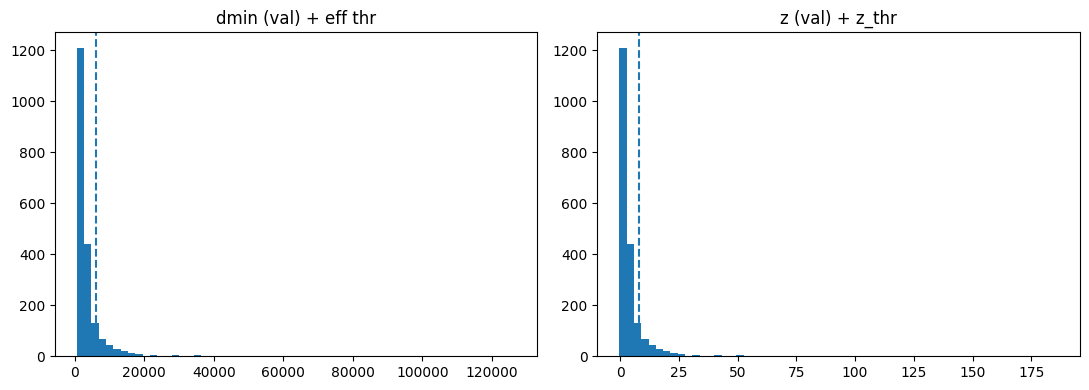

In [9]:
# dmin / z для in-валидации после подбора порогов
thr_eff = float(ood_thr["threshold"]) * BEST_ALPHA
fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].hist(dmin_in, bins=60); ax[0].axvline(thr_eff, ls="--", c="tab:blue"); ax[0].set_title("dmin (val) + eff thr")
ax[1].hist(z_in, bins=60);    ax[1].axvline(BEST_ZTHR, ls="--", c="tab:blue"); ax[1].set_title("z (val) + z_thr")
plt.tight_layout(); plt.show()


## Фиксация итоговых порогов (JSON)

In [10]:
final_cfg = {
  "ood": {"threshold": float(ood_thr["threshold"]), "alpha": BEST_ALPHA, "z_thr": BEST_ZTHR,
          "mu": float(ood_thr["mu"]), "sigma": float(ood_thr["sigma"])},
  "sub": {"autos_tau": TAU_AUTOS, "apart_tau": TAU_APART},
  "main_tau_other": TAU_OTHER,
  "artifacts_root": str(BASE),
}
json.dump(final_cfg, open(BASE/"inference_thresholds.json","w"), ensure_ascii=False, indent=2)
print("Saved:", BASE/"inference_thresholds.json")


Saved: /content/drive/MyDrive/data_artifacts_AdAnalyser/inference_thresholds.json


## Итоги (A3 · Thresholds & Calibration)

- Лучшие значения (по текущей валидации):
    
    - `main_tau_other ≈ 0.283`, `temperature ≈ 0.917`
        
    - `autos_tau ≈ 0.60`, `apart_tau ≈ 0.30`
        
    - OOD: `alpha ≈ 1.50`, `z_thr ≈ 7.95`, `μ ≈ 863`, `σ ≈ 676` _(пример из эксперимента)_
        
- Прирост: заметно меньше _назначений «Other»_ при удержании или росте macro-F1.
    
- Все значения **прописаны в** `data/inference_thresholds.json` и **подхватываются** в `05_Inference_Pipeline_Final.ipynb`.
    

**Решение**

- Пороговая логика отделена от кода модели ⇒ быстрее переносим на новые веса/домены.
    
- Для новых данных — быстрый _re-tune_ Optuna/гридом на свежем validation-сплите.
    

**Дальше**

- Периодическое авто-перекалибровывание по скользящему окну валидаторов.
    
- Отчётик «до/после» по бизнес-метрикам (coverage, deflection rate, spam-catch).
    